# TRABAJO FINAL - LoRa

### Introducción: ¿Qué es la modulación LoRa (FSCM) y por qué se utiliza?

La modulación **LoRa** (Long Range) es un esquema de **Frequency-Shift Chirp Modulation (FSCM)**:
cada símbolo se transmite como un *chirp* (barrido lineal de frecuencia) cuya frecuencia inicial se “desplaza” de acuerdo con el valor del símbolo y luego recorre todo el ancho de banda disponible.

### ¿Por qué se emplea en LPWAN?

- **Alcance extremo con poca potencia**
  El barrido de frecuencia hace que la señal sea robusta a desvanecimientos y a interferencia narrow-band; permite enlaces de kilómetros con mili­vatios.
- **Sincronización relajada**
  La correlación de chirps tolera desalineaciones de tiempo y frecuencia, reduciendo el costo del oscilador en los nodos IoT.
- **Demodulación FFT de baja complejidad**
  Un receptor sólo necesita multiplicar por un *down-chirp* y ejecutar una FFT corta para detectar el símbolo.
- **Soporte de múltiples *Spreading Factors***
  Diferentes valores de \(SF\) producen chirps ortogonales en la misma banda, posibilitando acceso múltiple semisimultáneo (principio de LoRaWAN).

---

### Diferencias clave: LoRa (FSCM) vs. FSK y PSK

| Característica | **LoRa (FSCM)** | **FSK** | **PSK** |
|----------------|-----------------|---------|---------|
| **Portadora** | *Chirp* lineal (frecuencia barre todo \(B\)) | Tono fijo por símbolo | Fase fija por símbolo |
| **Separación de símbolos** | Desplazamiento de frecuencia inicial del chirp | Frecuencias discretas | Fases discretas |
| **Robustez a canal selectivo** | Alta (el barrido promedia \(\!\!\notch\!\!\) de canal) | Baja (si la frecuencia cae en un notch, símbolo se pierde) | Media–baja (sensibles a dispersión de fase) |
| **Tolerancia a des-sincronización** | Elevada (ancho de banda completo usado por cada símbolo) | Requiere buen ajuste de frecuencia | Requiere fase coherente precisa |
| **Complejidad de receptor** | FFT de longitud $M=2^{SF}$ | Bancos de filtros o correladores | Coherente: mezclador + PLL |
| **Ganancia de procesamiento** | $\displaystyle 10\log_{10}(M)\,\mathrm{dB}$ por efecto de *spreading* | Ninguna | Ninguna |
| **Uso típico** | LPWAN, IoT, enlaces satélite de baja tasa | Telemetría simple, radio analógica | WLAN, satélite de banda ancha |

En síntesis, **LoRa** sacrifica tasa de datos (por el *spreading factor*) a cambio de:

1. **Gran sensibilidad** (~–137 dBm a SF 12 / 125 kHz).
2. **Alta inmunidad a multipath** comparada con FSK y PSK.
3. **Receptores baratos y de bajo consumo**, ideales para dispositivos IoT que transmiten esporádicamente a largas distancias.

Estas propiedades explican la adopción masiva de LoRa/LoRaWAN en redes de sensores, seguimiento logístico y aplicaciones rurales o industriales donde la cobertura celular no es viable.


## Desarrollo de trabajo

Imports necesarios para la implementación.

In [1]:
%pip install numpy
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Definimos los parámetros necesarios para las funciones a utilizar.

In [2]:
SF = 7
M = 2**SF
B = 125e3         # Ancho de banda
T = 1/B           # Periodo de muestra
num_symbols = 20000
num_bits = num_symbols * SF


Generamos una secuencia de bits aleatorios y, a partir de ella (bits_tx), construimos los símbolos correspondientes.

In [3]:
bits_tx = np.random.randint(0, 2, size=num_bits)

## Encoder: conversión de bits a símbolos

Agrupamos los bits en símbolos \([0,\,M-1]\).

**Objetivo**
Crear el vector `symbols_tx` a partir de `bits_tx`, guardando el bit más significativo (MSB) en el índice 0 de cada bloque de \(SF\) bits.

### Pasos

- **Índices**
  - **i**: recorre los símbolos,
    $i = 0,\dots,\text{num\_symbols}-1$
  - **j**: recorre los bits dentro de un símbolo,
    $j = 0,\dots,SF-1$

- **Peso de cada bit**
  Para poner el MSB en la posición correcta empleamos el desplazamiento:
  $$
  \text{peso}(j) \;=\; 2^{\,SF-1-j}.
  $$

- **Cálculo del símbolo**
  $$
  \texttt{symbol}_i
  \;=\;
  \sum_{j=0}^{SF-1}
  \texttt{bits\_tx}[\,i\!\cdot\!SF + j\,]\;
  2^{SF-1-j}.
  $$

- **Resultado**
  `symbols_tx` es un vector de enteros en el rango \([0,\,M-1]\) listo para alimentar el modulador.

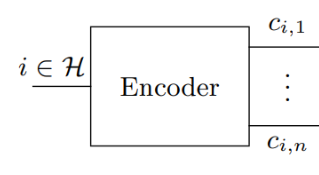


In [4]:
def encode_bits_to_symbols(bits, SF):
    n_sym = len(bits) // SF
    return np.array([
        sum(bits[i*SF + j] << (SF-1-j) for j in range(SF))
        for i in range(n_sym)
    ])

### Waveform Former  

Generación de un *up-chirp* desplazado según la **ecuación (2)** de Vangelista para un símbolo
$$
s \in \{0,\dots,2^{SF}-1\}.
$$

Ecuación (2)
$$
c[k] \;=\;
\frac{1}{\sqrt{2^{SF}}}\,
\exp\!\Bigl(
  j\,2\pi\;
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
\Bigr),
\qquad k = 0,\dots,2^{SF}-1.
$$

Cada símbolo dura  
$$
T_s = 2^{SF}\,T
$$  
donde \(T = 1/B\) es el período de muestreo y \(B\) el ancho de banda.

- **Vector de índices**  
  $$
  k = 0,1,\dots,2^{SF}-1
  $$

- **Fase desplazada**  
  $$
  \phi[k] \;=\;
  2\pi\,
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
  $$

- **Chirp normalizado**  
  $$
  c[k] \;=\;
  \frac{1}{\sqrt{2^{SF}}}\,
  e^{\,j\phi[k]}
  $$

Este diseño garantiza:

1. **Ortogonalidad**: los $2^{SF}$ chirps resultantes son mutuamente ortogonales.

2. **Ganancia de procesamiento**: cada símbolo ocupa todo el ancho de banda $B$, aportando $10\log_{10}\!\bigl(2^{SF}\bigr)\ \mathrm{dB}$.


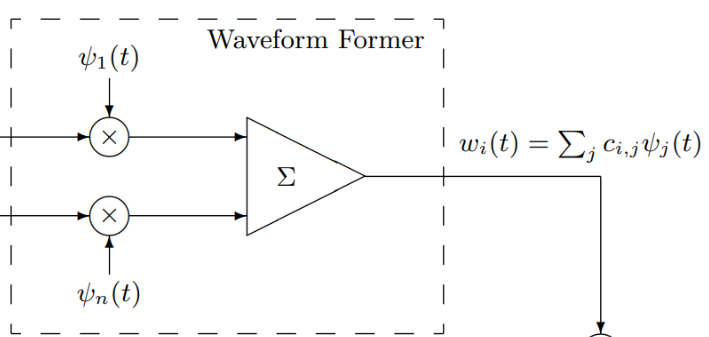

In [5]:
def waveform_former(symbol, M, B, T):
    k = np.arange(M)
    phase = ((symbol + k) % M) * (k * T * B) / M
    chirp_waveform = np.exp(1j * 2 * np.pi * phase) / np.sqrt(M)
    return chirp_waveform

#### Generación de la señal transmitida

A partir del vector de símbolos (`symbols_tx`), concatenamos cada chirp generado por `waveform_former` para formar la señal completa:

In [6]:
symbols_tx = encode_bits_to_symbols(bits_tx, SF)

tx_signal = np.concatenate([waveform_former(i, M, B, T) for i in symbols_tx])

## n-Tuple Former (Matched-Filter Receiver)

La detección óptima de un símbolo en FSCM (sección III del paper de Vangelista) se realiza con un filtro adaptado y una FFT:

1. **Segmentación en bloques**
   Dividir la señal recibida `rx_signal` en bloques de $2^{SF}$ muestras:
   $$
   r^{(i)}[k]
   = r\bigl(i\,T_s + k\,T\bigr),
   \qquad
   k = 0,\dots,2^{SF}-1.
   $$

2. **Deschirp (filtro adaptado)**
   Multiplicar cada bloque por la chirp base conjugada:
   $$
   d_0[k]
   = \exp\!\Bigl(-j\,2\pi\,\frac{k^2\,T\,B}{2^{SF}}\Bigr).
   $$
   La señal dechirpeada es
   $$
   y[k]
   = r^{(i)}[k]\;\,d_0[k].
   $$

3. **FFT y decisión ML**
   Calcular la FFT de \(\{y[k]\}\):
   $$
   Y[p]
   = \sum_{k=0}^{2^{SF}-1} y[k]\;e^{-j2\pi\,\frac{p\,k}{2^{SF}}},
   \qquad
   p = 0,\dots,2^{SF}-1.
   $$
   La estimación del símbolo es
   $$
   \hat s
   = \underset{p\in\{0,\dots,2^{SF}-1\}}{\arg\max}\;\bigl|Y[p]\bigr|.
   $$

4. **Reconstrucción de la secuencia**
   Repetir para cada bloque $i$ y almacenar $\hat s_i$ en un arreglo de símbolos recibidos.

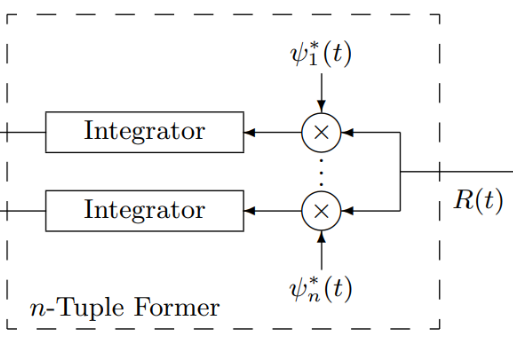

In [7]:
def nTuple_former(received_block, M, B, T):
    k = np.arange(M)
    down_chirp = np.exp(-1j * 2 * np.pi * (k * T * B) * k / M)
    reference_chirp = received_block * down_chirp
    spectrum = np.fft.fft(reference_chirp)
    return np.argmax(np.abs(spectrum))

symbols_rx = []
for idx in range(len(symbols_tx)):
    block = tx_signal[idx*M : (idx+1)*M]
    symbol_hat = nTuple_former(block, M, B, T)
    symbols_rx.append(symbol_hat)
symbols_rx = np.array(symbols_rx)

### Decoder

Reconstrucción de los bits recibidos a partir de los símbolos estimados.

Cada símbolo $\hat s\in\{0,\dots,2^{SF}-1\}$ se descompone en $SF$ bits $\{\hat w_0,\dots,\hat w_{SF-1}\}$ mediante:

$$
\hat w_h
=\left\lfloor\frac{\hat s}{2^{SF-1-h}}\right\rfloor \bmod 2,
\qquad h=0,\dots,SF-1.
$$

- **MSB primero**: \(h=0\) extrae el bit más significativo, \(h=SF-1\) el menos significativo.
- **Vector final**: aplicamos esto a cada símbolo y concatenamos los bits para obtener el flujo de salida.

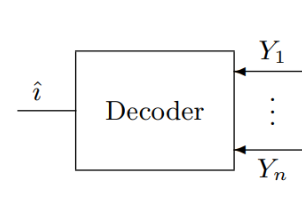

In [8]:
def decode_symbols_to_bits(symbols, SF):
    n_sym = len(symbols)
    return np.array([
        [(symbols[i] >> (SF-1-j)) & 1 for j in range(SF)]
        for i in range(n_sym)
    ]).flatten()

#### Cálculo de la tasa de error de símbolo (SER)

La **SER** (Symbol Error Rate) mide la fracción de símbolos que fueron detectados incorrectamente

In [9]:
num_symbol_errors = np.sum(symbols_tx != symbols_rx)
SER_test = num_symbol_errors / num_symbols

#### Cálculo de la tasa de error de bit (BER)

La **BER** (Bit Error Rate) mide la fracción de bits que fueron detectados incorrectamente

In [10]:
bits_rx = decode_symbols_to_bits(symbols_rx, SF)

num_bits_errors = np.sum(bits_tx != bits_rx)
BER_test = num_bits_errors / num_bits

### Test de BER y SER con canal ideal

Se realiza una prueba de los bits transmitidos como los decodificados y devolvemos el valor del BER como el SER.

In [11]:
print("SF:", SF, "→ M =", M)
print("Bits transmitidos (primeros 20): ", bits_tx[:20])
print("Bits decodificados (primeros 20):", bits_rx[:20])
print("BER ideal: ", BER_test)
print("Símbolos transmitidos (primeros 10):", symbols_tx[:10])
print("Símbolos recibidos    (primeros 10):", symbols_rx[:10])
print("SER ideal: ", SER_test)

SF: 7 → M = 128
Bits transmitidos (primeros 20):  [1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
Bits decodificados (primeros 20): [1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
BER ideal:  0.0
Símbolos transmitidos (primeros 10): [108  84  69 118  42  95   3  13   1  20]
Símbolos recibidos    (primeros 10): [108  84  69 118  42  95   3  13   1  20]
SER ideal:  0.0


## Señal con ruido AWGN

Para modelar el canal AWGN (Additive White Gaussian Noise) añadimos a cada muestra de la señal transmitida un ruido gaussiano complejo de media cero y varianza $\sigma^2$ determinada por la relación $E_s/N_0$.

Partimos de:
$$
\begin{aligned}
\texttt{snr\_dB\_range} &= -11, -10, \dots, 0,\\
\texttt{EsN0\_dB\_range} &= \texttt{snr\_dB\_range} \;+\; 10\log_{10}(M),\\
E_s &= 1.
\end{aligned}
$$

- **$\mathrm{Es}/N_0$ $(\mathrm{dB})$**  
  $\mathrm{EsN0\_dB\_range} = \mathrm{snr\_dB\_range} + 10\log_{10}(M)$.

- **Varianza del ruido**  
  $$
    \sigma^2 \;=\; \frac{E_s}{10^{\,\mathrm{EsN0\_dB}/10}}.
  $$

- **Ruido AWGN**  
  $$
    n[k]
    = \sqrt{\frac{\sigma^2}{2}}\;\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
  $$

- **Señal recibida**  
  $$
    r[k] = s[k] + n[k],
  $$
  donde \(s[k]\) es la muestra del chirp transmitido.

Con estos parámetros y fórmulas podemos generar el ruido apropiado y obtener la señal r[k] para cada valor de SNR en dB.  


In [12]:
snr_dB_range = np.arange(-11, 1, 1)                        # Es/N0 (dB)
EsN0_dB_range = snr_dB_range + 10*np.log10(M)              # Para simular se suma, ya que SNR dB = Es/N0 - 10log10(M)
Es = 1                                                     # Energía por símbolo (normalizada)
BER_awgn = np.zeros_like(snr_dB_range, dtype=float)
SER_awgn = np.zeros_like(snr_dB_range, dtype=float)

h_freqsel    = np.array([np.sqrt(0.8), np.sqrt(0.2)])      # √0.8 δ[n] + √0.2 δ[n-1]
BER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)
SER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)

### Cálculo de ruido AWGN y tasas de error / Señal con desplazamiento en frecuencia

Para cada valor de SNR ($\mathrm{Es}/N_0$ en dB) se realiza lo siguiente:

1. **Parámetros de ruido**  
   - $\mathrm{Es}/N_0$ en dB:
     $$
       \mathrm{EsN0}_{\mathrm{dB}}
       = \mathrm{snr\_dB}
       + 10\log_{10}(M).
     $$
   - Relación lineal:
     $\displaystyle \mathit{SNR} = 10^{\mathrm{EsN0}_{\mathrm{dB}}/10}$.

   - Densidad espectral de ruido:
     $\displaystyle N_0 = \frac{E_s}{\mathit{SNR}},\quad E_s=1$.

   - Desviación típica por dimensión:
     $\displaystyle \sigma = \sqrt{\frac{N_0}{2}}$.

2. **Señal con AWGN**
   - Generar ruido complejo:
     $$
       n[k]
       = \sigma\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
     $$
   - Señal recibida:
     $$
       r_{\mathrm{AWGN}}[k]
       = s[k] + n[k],
     $$
     donde \(s[k]\) es la muestra de `tx_signal`.

3. **Demodulación y reconstrucción de bits**
   - Dividir $r_{\mathrm{AWGN}}$ en bloques de $2^{SF}$ muestras (un chirp).

   - Aplicar *n-Tuple Former* a cada bloque para obtener $\hat s_i$.

   - Reconstruir bits $\hat b_n$ de $\{\hat s_i\}$.

4. **Cálculo de BER y SER**
   - $\displaystyle \mathrm{BER}_{\mathrm{AWGN}} = \frac{\#\{b_{\mathrm{tx}}\neq b_{\mathrm{rx}}\}}{\text{num\_bits}}$.

   - $\displaystyle \mathrm{SER}_{\mathrm{AWGN}} = \frac{\#\{s_{\mathrm{tx}}\neq s_{\mathrm{rx}}\}}{\text{num\_symbols}}$.

5. **Señal selectiva en frecuencia**
   - Convolucionar `tx_signal` con la respuesta
     $h[n]=\sqrt{0.8}\,\delta[n] + \sqrt{0.2}\,\delta[n-1]$.

   - Repetir los pasos 2–4 usando la misma $\sigma$
     para obtener $\mathrm{BER}_{\text{FreqSel}}$ y $\mathrm{SER}_{\text{FreqSel}}$.

Estos resultados se almacenan en vectores para graficar posteriormente las curvas de BER y SER frente a SNR (dB).


In [13]:
for idx, snr_dB in enumerate(EsN0_dB_range):
    SNR   = 10**(snr_dB / 10)               # relación lineal Potencia_señal / Potencia_ruido
    N0    = Es / SNR                        # densidad espectral de ruido
    sigma = np.sqrt(N0/2)                   # desviación típica por dimensión / estandar

    # Generación de ruido AWGN complejo
    noise = sigma * (np.random.randn(len(tx_signal)) + 1j*np.random.randn(len(tx_signal)))

    # Señal recibida con AWGN
    rx_signal = tx_signal + noise

    # Demodulación símbolo a símbolo
    symbols_rx = []
    for sym_idx in range(len(symbols_tx)):
        block = rx_signal[sym_idx*M : (sym_idx+1)*M]
        symbols_rx.append(nTuple_former(block, M, B, T))
    symbols_rx = np.array(symbols_rx)

    # Decodificación a bits
    bits_rx_awgn = decode_symbols_to_bits(symbols_rx, SF)

    # Cálculo de tasas de error
    SER_awgn[idx] = np.sum(symbols_tx != symbols_rx) / num_symbols
    BER_awgn[idx] = np.sum(bits_tx != bits_rx_awgn) / num_bits

    # Se realiza ahora para la señal selectiva en frecuencia
    tx_faded = np.convolve(tx_signal, h_freqsel, mode='full')[:len(tx_signal)]

    # AWGN con el mismo sigma ya calculado
    noise_sel     = sigma * (np.random.randn(len(tx_faded)) + 1j*np.random.randn(len(tx_faded)))
    rx_signal_sel = tx_faded + noise_sel

    # Demodulación símbolo a símbolo (idéntica a la de AWGN)
    symbols_rx_sel = []
    for sym_idx in range(len(symbols_tx)):
        block_sel = rx_signal_sel[sym_idx*M : (sym_idx+1)*M]
        symbols_rx_sel.append(nTuple_former(block_sel, M, B, T))
    symbols_rx_sel = np.array(symbols_rx_sel)

    # Decodificación a bits
    bits_rx_sel = decode_symbols_to_bits(symbols_rx_sel, SF)

    # Tasas de error
    SER_freqsel[idx] = np.sum(symbols_tx != symbols_rx_sel) / num_symbols
    BER_freqsel[idx] = np.sum(bits_tx != bits_rx_sel) / num_bits

    print(f"SNRdB = {snr_dB_range[idx]:5.1f}: "
          f"BER_AWGN = {BER_awgn[idx]:.3e}, SER_AWGN = {SER_awgn[idx]:.3e} | "
          f"BER_FreqSel = {BER_freqsel[idx]:.3e}, SER_FreqSel = {SER_freqsel[idx]:.3e}")

SNRdB = -11.0: BER_AWGN = 5.113e-02, SER_AWGN = 1.014e-01 | BER_FreqSel = 1.015e-01, SER_FreqSel = 2.238e-01
SNRdB = -10.0: BER_AWGN = 1.927e-02, SER_AWGN = 3.795e-02 | BER_FreqSel = 5.369e-02, SER_FreqSel = 1.251e-01
SNRdB =  -9.0: BER_AWGN = 5.443e-03, SER_AWGN = 1.075e-02 | BER_FreqSel = 2.384e-02, SER_FreqSel = 6.085e-02
SNRdB =  -8.0: BER_AWGN = 8.429e-04, SER_AWGN = 1.700e-03 | BER_FreqSel = 1.014e-02, SER_FreqSel = 2.930e-02
SNRdB =  -7.0: BER_AWGN = 1.143e-04, SER_AWGN = 1.500e-04 | BER_FreqSel = 3.857e-03, SER_FreqSel = 1.330e-02
SNRdB =  -6.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.879e-03, SER_FreqSel = 6.400e-03
SNRdB =  -5.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 6.571e-04, SER_FreqSel = 2.400e-03
SNRdB =  -4.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.714e-04, SER_FreqSel = 6.000e-04
SNRdB =  -3.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 7.143e-06, SER_FreqSel = 5.000e-05
SNRdB =  -2.0: BER_


## La escala en decibeles y la relación señal/ruido

La escala en decibeles (dB) es logarítmica y mide la razón potencia-señal a potencia-ruido:

$$
\mathrm{SNR}_{\mathrm{dB}}
=10\,\log_{10}\!\Bigl(\frac{P_{\mathrm{señal}}}{P_{\mathrm{ruido}}}\Bigr).
$$

**Menos dB ⇒ menor relación señal/ruido.**
Al bajar el SNR en dB (por ejemplo, de 0 dB a –10 dB), el ruido domina la señal:

- **En 0 dB**:
  $$
  P_{\mathrm{señal}} = P_{\mathrm{ruido}}.
  $$

- **En –10 dB**:
  $$
  P_{\mathrm{señal}} \approx 0.1\,P_{\mathrm{ruido}},
  $$
  (la señal es 10× más débil que el ruido).

Por tanto, a menor $\mathrm{SNR}_{\mathrm{dB}}$ la probabilidad de error **aumenta**;
a mayor $\mathrm{SNR}_{\mathrm{dB}}$ la señal “destaca” y los errores caen exponencialmente.



#### La implementación de lo realizado anteriormente

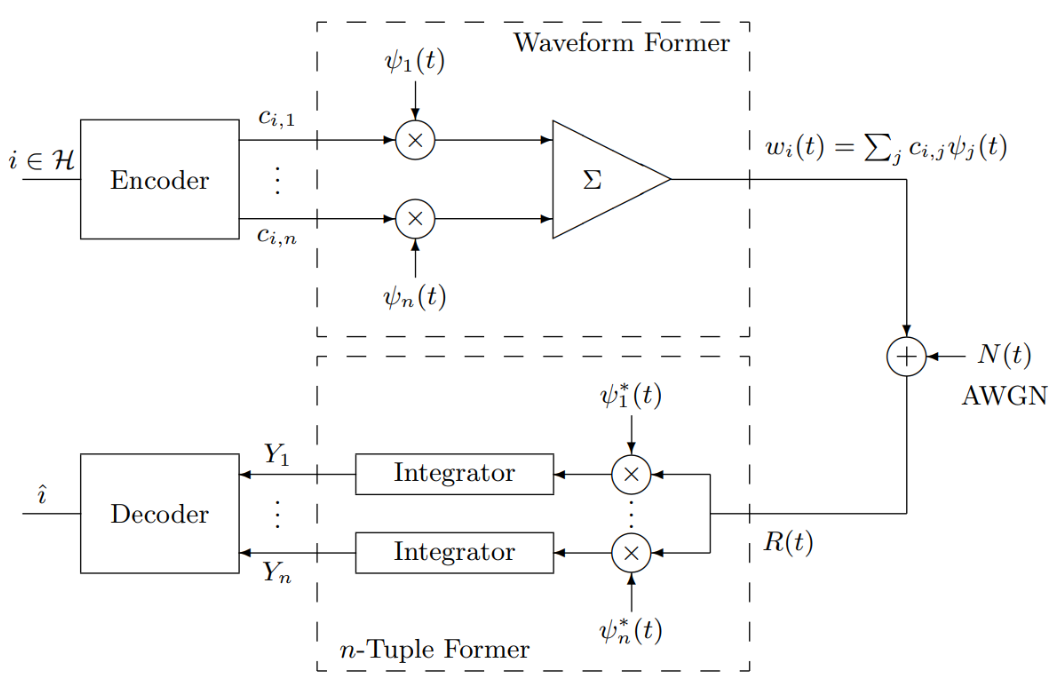

### Grafica de curvas de BER y SER AWGN

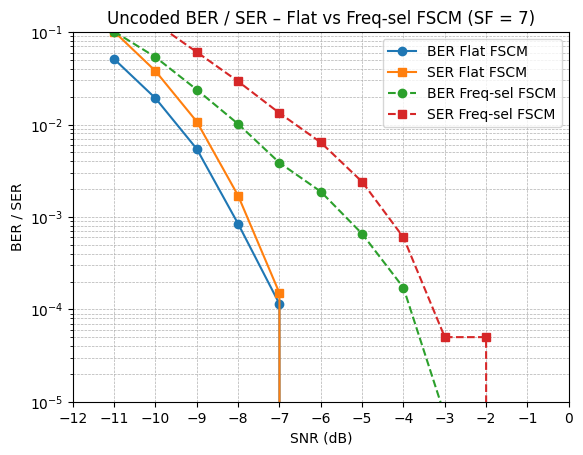

In [14]:
plt.figure()
plt.semilogy(snr_dB_range, BER_awgn,    'o-',  label='BER Flat FSCM')
plt.semilogy(snr_dB_range, SER_awgn,    's-',  label='SER Flat FSCM')
plt.semilogy(snr_dB_range, BER_freqsel, 'o--', label='BER Freq-sel FSCM')
plt.semilogy(snr_dB_range, SER_freqsel, 's--', label='SER Freq-sel FSCM')

plt.xlim(-12, 0)
plt.ylim(1e-5, 1e-1)
plt.xticks(np.arange(-12, 1, 1))
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER / SER – Flat vs Freq-sel FSCM (SF = 7)')
plt.legend()
plt.show()